In [33]:
import matplotlib.pyplot as plt

# Reading the data



In [1]:
import pandas as pd

import plotly.express as px
import plotly.graph_objs as go

In [2]:
FILE_PATH = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/csv_files/EN2_STAR_MON_0100725706_20070516T060226_20071005T074409.csv'

In [3]:
df = pd.read_csv(FILE_PATH)
df.head()

,DATE,WHITEFLUX
0,2007-05-16 18:11:00.787644,75564.110
1,2007-05-16 18:19:32.829687,75574.570
2,2007-05-16 18:28:04.871730,75547.414
3,2007-05-16 18:36:36.913772,75688.330
4,2007-05-16 18:45:08.955815,75712.540


In [4]:
import numpy as np

x = df.DATE.to_numpy()
y = df.WHITEFLUX.to_numpy()

# Mathematical Requirements

## Discrete-time Fourier transform (DTFT)

$$  X[k] = X(\omega_k) = \sum_{n=0}^{L-1} x[n]e^{-j2\pi \frac{k}{N}n}  $$

If $N \ge L$, then:

$$  X[k] = \sum_{n=0}^{N-1} x[n]e^{-j2\pi \frac{k}{N}n}  $$

## Convolution

$$  f(t) * g(t) = (f*g)(t) \triangleq \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau $$

### Convolution theorem

Taking the Fourier transform of $f(t) * g(t)$, we have:

$$ \mathcal{F}\{ f(t) * g(t) \} = \int_{-\infty}^{\infty} \Bigg[ \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau \Bigg]e^{-j2\pi\mu t}dt \\ $$

$$ \mathcal{F}\{ f(t) * g(t) \} = \int_{-\infty}^{\infty} f(\tau) \Bigg[ \int_{-\infty}^{\infty} g(t - \tau)e^{-j2\pi\mu t}dt \Bigg]d\tau \\ $$

$$ ... demonstration \\ $$

$$ f(t) * g(t) \iff G(\mu)F(\mu) \\ $$ 


The double arrow means that the expression on the right side is obtained by taking the Fourier transform of the expression on the left, as well as, the expression on the left was obtained by taking the inverse Fourier transform of the expression on the right.


# Frequency Domain Filtering Fundamentals

---

## Introduction
Filtering in the frequency domain consists of modifying the Fourier transform of an signal (can be a image, a media file, a light curve...) and then computing the inverse tranform to obtained the processed result. Thus, given a digital signal, $f(x)$, of size $M$, the basic filtering equation is: 

$$
g(x) = \mathcal{F}^{-1}[H(u)F(u)] \\
$$

where $\mathcal{F}^{-1}$ is the Inverse discrete Fourier transform, $F(u)$ is the Fourier transform of the given function $f(x)$ (input), $H(u)$ is the _filter transfer function_, and $g(x)$ is the filtered signal (output). Both $F$, $H$ and $G$ are arrays of size $M$, the same as the input signal. The product $H(u)F(u)$ is formed using array multiplication; that is, $G(i, k)=H(i, k)F(i, k)$.



## Expand lightcurves borders


Para realizar a filtragem das curvas de luz nesse trabalho, utilizaremos o algoritmo da Transformada rápida de Fourier (FFT) a fim de converter o sinal em seu domínio original no domínio da frequência. A escolha do FFT é simples, o algoritmo possui complexidade de $O(N\space \log N)$ enquanto a aplicação da definição da Transformada discreta de Fourier (DTFT) é de complexidade $O(N^2)$, sendo $N$ o tamanho dos dados, ou seja, ele é bem mais eficiente computacionalmente.


Porém, o FFT tem algumas particulares que podem nos gerar problemas e resultados inesperados. O algoritmo é baseado no método de dobramentos sucessivos [Gonzalez and Woods, 1992] e isso significa que ele presume que o sinal recebido seja periódico e que o número de amostras seja um número inteiro e potência de 2, mas esse último não é um requisito geral. Contudo, a primeira conjectura é bastante relavante para não termos distorção no resultado do algoritmo. Coletar $M$ amostras de um sinal, o que o CoRoT fez para nós, equivale a recordar um pedaço finito do sinal real, ou seja, pegamos uma janela entre $T_1$ e $T-2$ de um sinal definido de ${-\infty}$ até ${+\infty}$. Há a possíbilidade de que essa janela represente perfeitamente as oscilações do sinal original, em outras palavras, que ela apresente períodos completos de todas as frequências, assim teremos uma FFT sem distorções, mas é estatísticamente improvavel que isso ocorra. Nesse caso, teremos períodos incompletos, o que irá introduzir distorções de alta frequência no sinal que, em geral, se encontrarão nas extremidades do sinal, visto que a FFT é recursiva, ou seja, o resultado do ponto $P+1$ depende do resultado no ponto $P$. 

Umas das maneiras de reduzir essas distorções é a através da escolha de diferentes janelamentos do sinal, conteudo como não queremos perder nenhum dado das curvas de luz, iremos utilizar o método de expansão das 'bordas' do nosso array. Dado um array $A$ de tamanho $K$, iremos adicionar $N$ pontos antes do primeiro ponto, $A[0]$ e $N$ pontos depois do último ponto, $A[-1]$. A definição dos valores dos $N$ será dada a partir do comportamento de $E(i)$:

$$ E(i) = \begin{cases}
   A[0], &\text{se } i < 0 \\
   A[-1], &\text{se } i > -1
\end{cases} \\ $$

Ou seja, antes de $A[0]$ adicionaremos $N$ pontos de mesmo valor que $A[0]$ antes do primeiro termo e depois de $A[-1]$ adicionaremos $N$ pontos de mesmo valor de $A[-1]$ depois do último termo.

In [5]:
def artifical_borders(array, num):
  aux_pre = np.zeros(num)
  aux_pos = np.zeros(num)
  i = 0
  for i in range(num):
    aux_pre[i] = array[0]
    aux_pos[i] = array[-1]
  
  return np.concatenate((aux_pre, array, aux_pos)).ravel()

In [6]:
# Defining the numbers of points to be added

param = 70

In [7]:
y_artifical_borders = artifical_borders(y, param)

print("The original length was:", len(y), ", and now we have:", len(y_artifical_borders), "\nThe difference is:", (len(y_artifical_borders) - len(y) ))

The original length was: 23952 , and now we have: 24092 
The difference is: 140


## Avoiding _wraparound_ error

Zero Padding, $f_{zp}$, has the following definition: 

$$ f_{zp}(x) \triangleq \begin{cases}
   f(x), &\text{if } |m| < N/2 \\
   0, &\text{otherwise }
\end{cases} $$

where: 

$m = 0, \pm1, \pm2, \pm3, ...\pm M_{h}$, with $M_h \triangleq (M-1)/2 $ for $M$ odd, and $M/2-1$ for $M$ even. 

<br />Padding remove the implicit periodicity of the funcion that can appeared on the filtered data.
In other terms, the padding prevents the convolution of two functions from generating unexpected (periodic) results.

In [8]:
# Funciona - original

def padding(array):
  return np.append(array, np.zeros(len(array)))

In [9]:
y_padding = padding(y_artifical_borders)

print("The previous length was:", len(y_artifical_borders), ", and now we have:", len(y_padding), "\nThe difference is:", (len(y_padding) - len(y_artifical_borders) ))

The previous length was: 24092 , and now we have: 48184 
The difference is: 24092


-> Novo codigo
from math import log2, ceil

def padding(array):

  final_length = 2*len(array)
  add = (2**ceil(log2(final_length))) - final_length
  
  return np.append(array, np.zeros(len(array)+add)), add

y_padding, add = padding(y_artifical_borders)

## Centering the transform

Specification of $H(u)$ is simplified considerably by using functions that are symmetric about their center, which requires that $F(u)$ be centered also. This is accomplished by multipying the input signal, $f(x)$, by $(-1)^{x}$, where $x$ is the array index, prior to computing its Fourier transform. 

In [10]:
def multiplying_by_minus_one_to_index(array):
  i = 0
  new_array = np.ones(len(array))

  for i in range(len(array)):
    new_array[i] = array[i] * ( (-1)**(i) )
  
  return new_array

In [11]:
y_multiplied = multiplying_by_minus_one_to_index(y_padding)

## Fourier Transform

$$ \mathcal{F}\{f(\xi)\} = \hat{f}(\xi) \triangleq \int_{-\infty}^{\infty} f(\xi)\space e^{-j2\pi\mu \xi}d\xi \\ $$

where $\xi$ is any real number, 

In [12]:
def fourier_transform(array):
  fft = np.fft.fft(array)
  
  return fft

In [13]:
y_fft = fourier_transform(y_multiplied)

In [14]:
y_fft

array([-16673.57200001+8.36371328e-09j,  47796.28989974+1.23804272e+04j,
         1859.81772268+2.77695961e+04j, ...,
        79054.83095289-8.48836152e+03j,   1859.81772268-2.77695961e+04j,
        47796.28989975-1.23804272e+04j])

## Butterworth transfer function

$$ G_{n}(\omega)  = |H_{n}(j\space\omega)| = \frac{1}{ \sqrt{ 1 + \big(\frac{\omega}{\omega_c}\big)^{2n} } } \\ $$





nyquist = 0.5 < x < 0.01 muito ruim

ordem = 3 e 4 podem alterar o resultado, deve ser menor (talvez)

In [15]:
cutoff_freq = 0.2 # Nyquist
order = 2

In [16]:
(n_time, columns) = df.shape
n_time

23952

In [17]:
d0 = cutoff_freq * n_time
xc = n_time

In [18]:
#filter = np.zeros(int(2*(n_time + 2*param)))
filter = np.zeros(len(y_fft))
len(filter)

48184

### Creating a filter array


In [38]:
int(2.0*n_time + param)

47974

In [39]:
len(y_ifft)

48184

In [40]:
len(y_fft)

48184

In [35]:
for i in range(int(2.0*n_time + param)):
#for i in range(len(y_fft)):
   filter[i] = 1.0/ (1.0+(abs(i-(xc-1.0))/d0)**(2.0*order))

In [21]:
filter

array([0.00159771, 0.00159798, 0.00159824, ..., 0.00152549, 0.00152524,
       0.00152499])

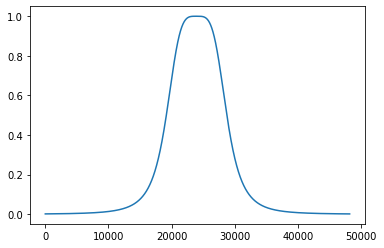

In [36]:
plt.plot(filter)

In [47]:
filter.mean()

0.2203324531272623

### Applying the filter -> Array product

Consider the following 2x2 matrices:

$$
\begin{bmatrix}
  a_{11} & a_{12} \\ a_{21} & a_{22}
\end{bmatrix} \kern1em and \kern1em
\begin{bmatrix}
  b_{11} & b_{12} \\ b_{21} & b_{22}
\end{bmatrix}
$$

The array product is defined by

$$
\begin{bmatrix}
  a_{11} & a_{12} \\ a_{21} & a_{22}
\end{bmatrix}
\begin{bmatrix}
  b_{11} & b_{12} \\ b_{21} & b_{22}
\end{bmatrix} = 
\begin{bmatrix}
  a_{11}b_{11} & a_{12}b_{12} \\ a_{21}b_{21} & a_{22}b_{22}
\end{bmatrix}
$$


In [37]:
y_butter = filter * y_fft
y_butter

array([-26.63954048+1.33627922e-11j,  76.377367  +1.97836366e+01j,
         2.97244137+4.43825733e+01j, ..., 120.59765221-1.29489426e+01j,
         2.83667275-4.23553639e+01j,  72.8889106 -1.88800397e+01j])

## Inverse Fourier Transform

$$ f(x) = \int_{-\infty}^{\infty}\mathcal{F}(\xi)\space e^{j2\pi x\xi} d\xi \\ $$

where $x$ is any real number, 

In [23]:
def inverse_fourier_transform(array):
  ifft = np.fft.ifft(array)

  return ifft

In [24]:
y_ifft = np.real(inverse_fourier_transform(y_butter))
y_ifft

array([ 46106.63946323, -60407.59273634,  70102.65898028, ...,
        -5461.39430492,  15156.46054716, -29457.41382112])

## Removing Zero Padding

In [25]:
# Funciona - original

y1 = y_ifft[:int(len(y_ifft)/2)]

print("The before length was:", len(y_ifft), ", and now we have:", len(y1))

The before length was: 48184 , and now we have: 24092


In [26]:
y1

array([ 46106.63946323, -60407.59273634,  70102.65898028, ...,
       -70754.70992205,  60969.46637127, -46535.49447273])

-> Novo codigo

def no_padding(array_padded):
  sub = int( (len(array_padded) + add)/2 )
  return array_padded[:-sub]

y1 = no_padding(y_ifft)

## Cuting artificial borders

In [27]:
param = param # equals 70, but we might change that value

In [28]:
y2 = np.delete(y1, np.s_[:param])
y3 = np.delete(y2, np.s_[-param:])

y3

array([ 75576.46928051, -75592.94595914,  75615.6268766 , ...,
       -76233.67350243,  76241.63092286, -76251.32502471])

## Re-multiplying data by $(-1)^{i}$

In [29]:
y_filtered = multiplying_by_minus_one_to_index(y3)
y_filtered

array([75576.46928051, 75592.94595914, 75615.6268766 , ...,
       76233.67350243, 76241.63092286, 76251.32502471])

## Results

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                           mode='lines',
                           name='Original Light Curve'))

fig.add_trace(go.Scatter(x=x, y=y_filtered,
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Light Curve before and after the Butterworth filter',
                   xaxis_title='Date',
                   yaxis_title='Whiteflux')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Generating algorithm...

---

Since all the Mathematical and Computacional requirements have been prosecuted, we are going to summary all this on a single algorithm.

In [31]:
def butterworth_filtering(original_array):
  pass
    